In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import aplpy
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vaex

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from itertools import product
from m33_utils import open_and_select, deg_to_deproj
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
from matplotlib import patheffects

np.seterr(all='ignore')

sns.set(style='ticks', 
        rc={'font.family'          : 'serif',
            'text.usetex'          : True,
            'axes.axisbelow'       : True,
            'mathtext.fontset'     : 'cm',
            'mathtext.default'     : 'regular',
            'xtick.direction'      : 'in',
            'ytick.direction'      : 'in',
            'xtick.major.width'    : 1.1,
            'ytick.major.width'    : 1.1,
            'axes.labelpad'        : 5.0,
            'legend.framealpha'    : 0.95,
            'legend.handlelength'  : 1.2,
            'legend.handletextpad' : 0.5,
       })

pal = sns.color_palette('colorblind')
dark = sns.color_palette('dark')
sns.set_palette(pal)

def add_colorbar(fig, ax, cmap='viridis', vmin=0, vmax=1,
                 norm='Normalize', n_colors=None, norm_args={},
                 offset=0.0175, width=0.0225, label='Number of stars'):
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+offset, pos.y0, width, pos.height])
    cmap_mpl = plt.get_cmap(cmap, n_colors)
    norm_mpl = getattr(mpl.colors, norm)(**norm_args, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_mpl, cmap=cmap_mpl),
                        cax=cax, label=label)
    return cbar

In [2]:
ds = open_and_select('../legacy_phot/M33_full_matched.hdf5')

In [3]:
df_cl = pd.read_csv('data/clusters_withfield.csv', index_col=0)
for idx, row in df_cl.iterrows():
    ds.select_circle('RA', 'DEC', row.RA, row.Dec, row.Radius/3600, name=f'cluster_{idx}')
    if ds.selected_length(f'cluster_{idx}') == 0:
        print(f'Cluster {idx} outside of 6-filter footprint')

2 0
8 780
11 258
15 439
17 434
19 0
25 423
27 393


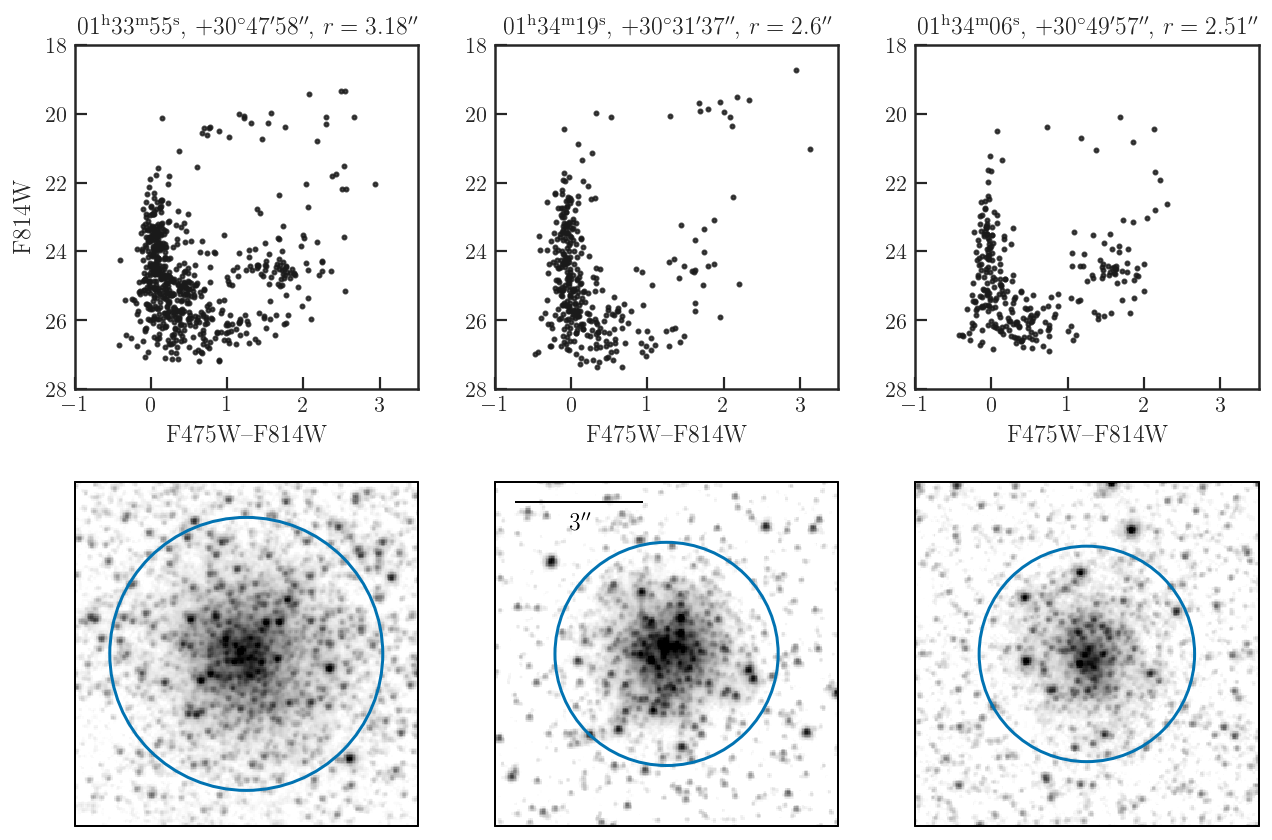

In [35]:
fig = plt.figure(figsize=(9, 6))

for i, (idx, row) in enumerate(df_cl.iloc[[1,3,4]].iterrows()):
    ax = fig.add_subplot(2, 3, i+1)
    plt.sca(ax)
    ds.scatter('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', selection=f'OPT_GST & cluster_{idx}',
               color='k', s=4, alpha=0.8)
    ax.set_xlabel('F475W--F814W')
    ax.set_ylabel('F814W') if (i == 0) else ax.set_ylabel('')
#     if i > 0: ax.set_yticklabels([])
    ax.set_xlim(-1, 3.5)
    ax.set_ylim(28, 18)
    ra, dec = SkyCoord(row.RA, row.Dec, unit='deg'
                      ).to_string('hmsdms', decimal=False, precision=0, format='latex'
                                 ).replace('{','{{').replace('}','}}').split()
    ax.set_title(f'{ra}, {dec}, $r={row.Radius}^{{\prime\prime}}$')

    f = aplpy.FITSFigure(f'data/cutouts/cluster_{idx}.fits',
                         north=True, figure=fig, subplot=(2, 3, i+4))
    f.set_theme('publication')
    f.recenter(row.RA, row.Dec, radius=4/3600)
    f.show_grayscale(stretch='log', interpolation='nearest', vmin=0.05, vmax=4)
    f.show_circles(row.RA, row.Dec, radius=row.Radius/3600, zorder=1000, facecolor='None',
                   edgecolor=pal[0], linewidth=1.5, layer='circ')
    if i == 1:
        f.add_scalebar(3/3600, label='$3^{\prime \prime}$', corner='top left')
    aplpy.AxisLabels(f).hide()
    aplpy.TickLabels(f).hide()
    aplpy.Ticks(f).hide()

fig.tight_layout(h_pad=1.5, w_pad=2)
fig.savefig('figures/clusters.pdf', dpi=300, bbox_inches='tight')

In [1]:
df_lggs = vaex.from_csv('data/m33_lggs.tsv', sep=';', comment='#', na_values=[' '*i for i in range(10)])
df_lggs['Bmag'] = df_lggs['Vmag']+df_lggs['B-V']
df_lggs['Rmag'] = df_lggs['Vmag']-df_lggs['V-R']
df_lggs['Imag'] = df_lggs['Rmag']-df_lggs['R-I']
df_lggs.drop(df.get_column_names())
df_lggs.dropna(['Imag'], inplace=True) # = df_lggs[df_lggs.Imag.notna()]

# df_lggs.rename(lambda x: x.replace('-','_'), axis='columns', inplace=True)
# ds_lggs = vaex.from_pandas(df_lggs)


NameError: name 'vaex' is not defined

In [1]:
lim = [[-1.5, 5.5], [28, 14]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
plt.sca(ax1)
ds_lggs.plot('Vmag-Imag', 'Imag', f='log10', limits=lim, vmin=0, vmax=2.03, #shape=420,
             xlabel='$V-I$', ylabel='$I$', colormap='viridis', colorbar=False)

plt.sca(ax2)
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', vmin=0, vmax=3.05, f='log10', selection='OPT_GST',
        xlabel='F475W--F814W', ylabel='F814W', colormap='viridis', limits=lim, colorbar=False)

fig.tight_layout(w_pad=7)
add_colorbar(fig, ax1, cmap='viridis', vmin=1, vmax=10**2.03,
             norm='LogNorm', label='Number of stars')
add_colorbar(fig, ax2, cmap='viridis', vmin=1, vmax=10**3.05,
             norm='LogNorm', label='Number of stars')

# ax1.set_yticks([14, 16, 18, 20, 22, 24])
# ax2.set_yticks([16, 18, 20, 22, 24])
ax1.set_title('LGGS')
ax2.set_title('This work')
fig.savefig('figures/LGGS_comparison.pdf', dpi=300, bbox_inches='tight')

NameError: name 'plt' is not defined

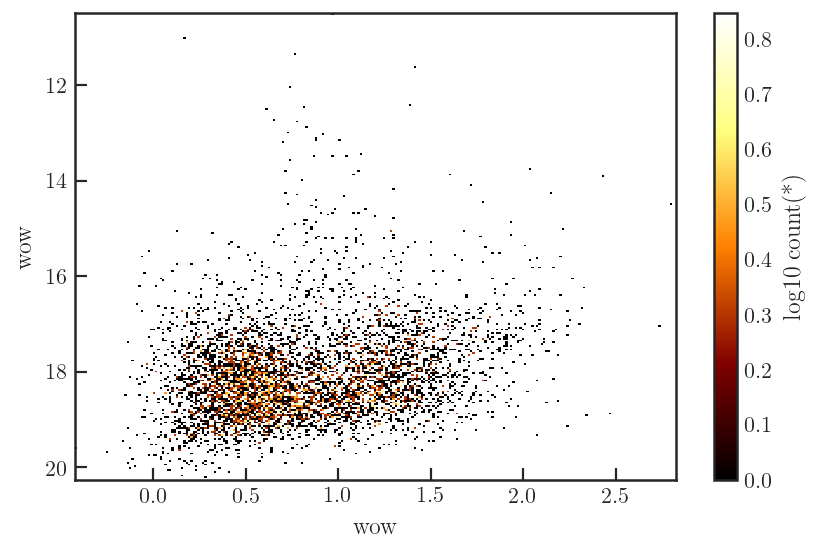

In [6]:
ds_gaia = vaex.from_csv('../gaia_all.csv')
ds_gaia.plot('bp_rp', 'phot_rp_mean_mag', f='log10', xlabel='wow', ylabel='wow')
plt.gca().invert_yaxis()

/astro/users/mdurbin/miniconda3/envs/astroconda_dev/lib/python3.7/site-packages/vaex/viz/mpl.py:779: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = pylab.subplot(gs[row_offset + row * row_scale:row_offset + (row + 1) * row_scale, column * column_scale:(column + 1) * column_scale])


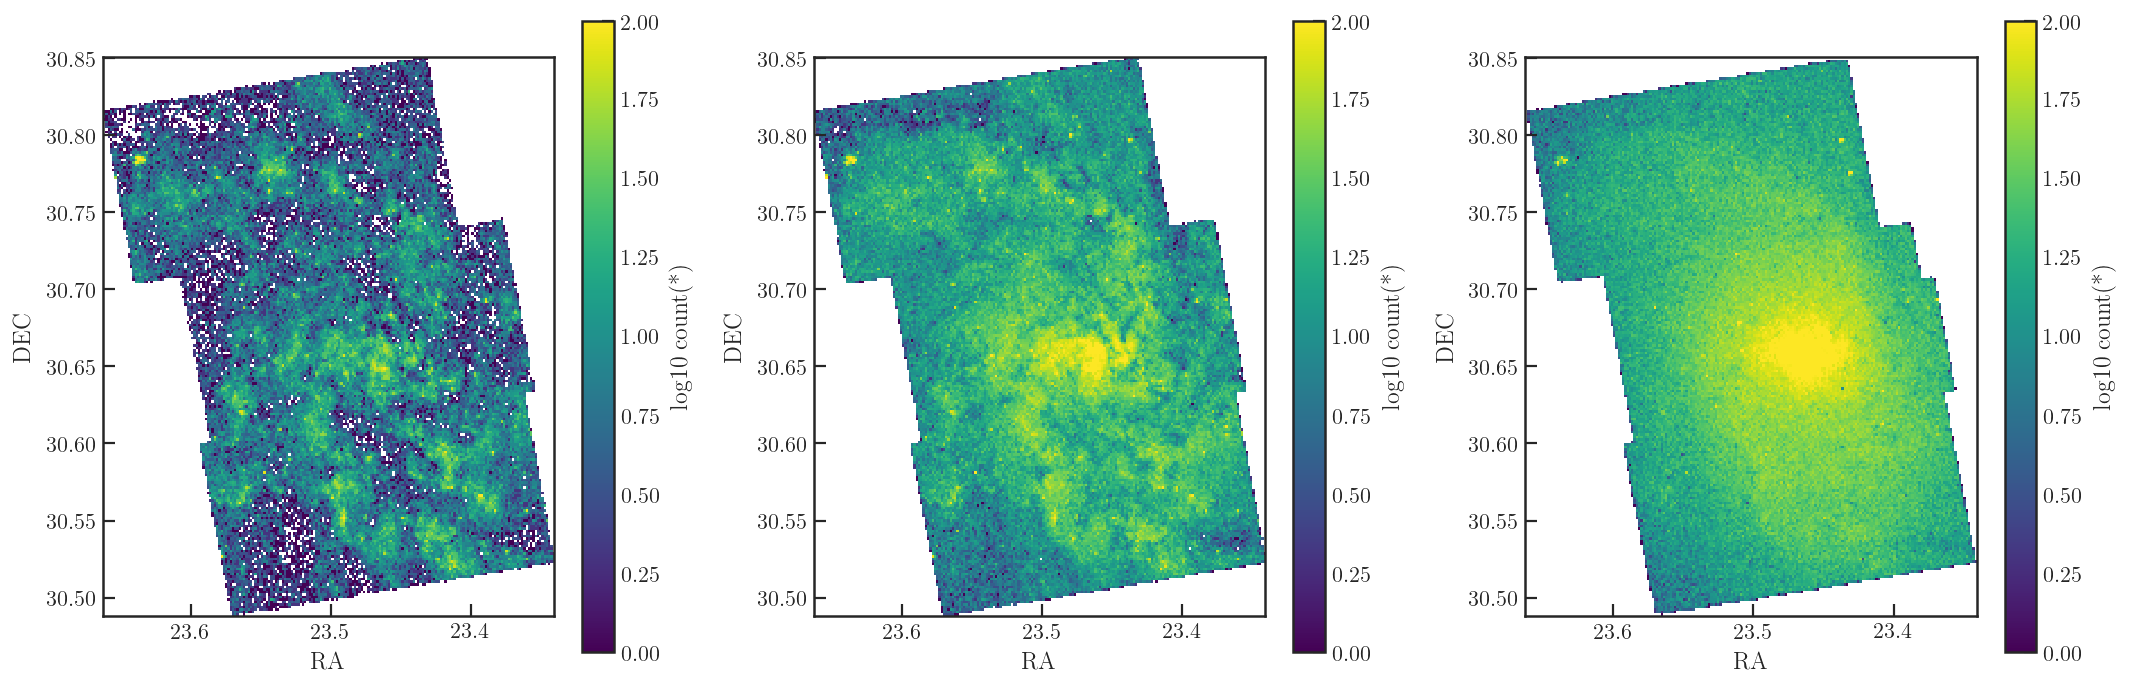

In [7]:
# 0.9+       &  24.14 &  25.10 &  25.78 &  25.39 &  23.72 &  23.04 \\
ds.plot('RA', 'DEC', limits='minmax', aspect=1.1, figsize=(15,5), tight_layout=True,
        shape=(200,220), vmin=0, vmax=2, f='log10',
        visual=dict(column='selection'), 
        selection=['(F275W_VEGA < 24.0) & (F336W_VEGA < 25) & UV_GST',
                   '(F475W_VEGA < 24.5) & (F814W_VEGA < 24) & OPT_GST',
                   '(F110W_VEGA < 22.5) & (F160W_VEGA < 22) & IR_GST'],
        colormap='viridis')
for ax in plt.gcf().get_axes():
    ax.invert_xaxis()

In [8]:
distA, distB = deg_to_deproj(*ds[['RA','DEC']].values.T)

In [9]:
ds['distA'] = distA
ds['distB'] = distB
ds['radius'] = (distA**2 + distB**2)**0.5

In [10]:
for density in [[0, 0.15], [0.15, 0.3], [0.3, 0.6], [0.6, 0.9], [0.9, 1000]]:
    rad = ds.median_approx('radius', binby='DENSITY', shape=1, limits=density, percentile_shape=10000,
                           percentile_limits='minmax', selection='(F160W_VEGA < 20.7) & (F160W_VEGA > 19.7)')
    print(density, rad.round(3)[0])

[0, 0.15] 2.679
[0.15, 0.3] 1.751
[0.3, 0.6] 0.908
[0.6, 0.9] 0.379
[0.9, 1000] 0.152


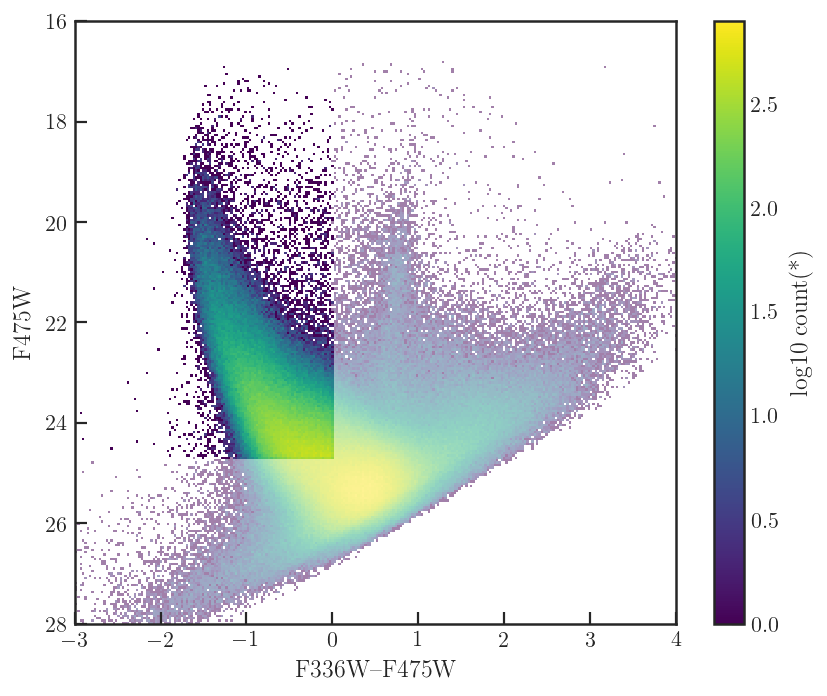

In [11]:
ds.plot('F336W_VEGA-F475W_VEGA', 'F475W_VEGA', f='log10', xlabel='F336W--F475W', ylabel='F475W',
        limits=[[-3,4], [28, 16]], colormap='viridis', figsize=(6,5),
        selection=['F336W_GST & F475W_GST',
                   '(F475W_VEGA < 24.7) & (F336W_VEGA-F475W_VEGA < 0) & F336W_GST & F475W_GST'])

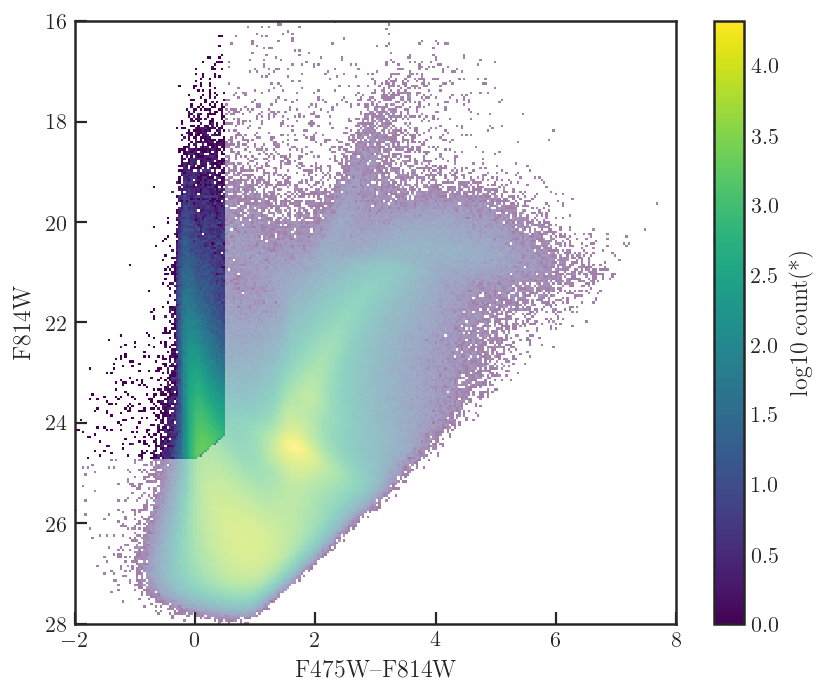

In [16]:
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', f='log10', xlabel='F475W--F814W', ylabel='F814W',
        limits=[[-2,8], [28, 16]], colormap='viridis', figsize=(6,5),
        selection=['OPT_GST',
                   '(F475W_VEGA < 24.7) & (F814W_VEGA < 24.7) & (F475W_VEGA-F814W_VEGA < 0.5) & OPT_GST'])

In [17]:
ob_opt = '(F475W_VEGA < 24.7) & (F814W_VEGA < 24.7) & (F475W_VEGA-F814W_VEGA < 0.5) & OPT_GST'
ds.selected_length(ob_opt)

427454

In [15]:
ob_selection = '(F475W_VEGA < 24.7) & (F336W_VEGA-F475W_VEGA < 0)'
ob_selection += ' & (F336W_VEGA-F475W_VEGA > -3) & F336W_GST & F475W_GST'
ds.selected_length(ob_selection)

329522

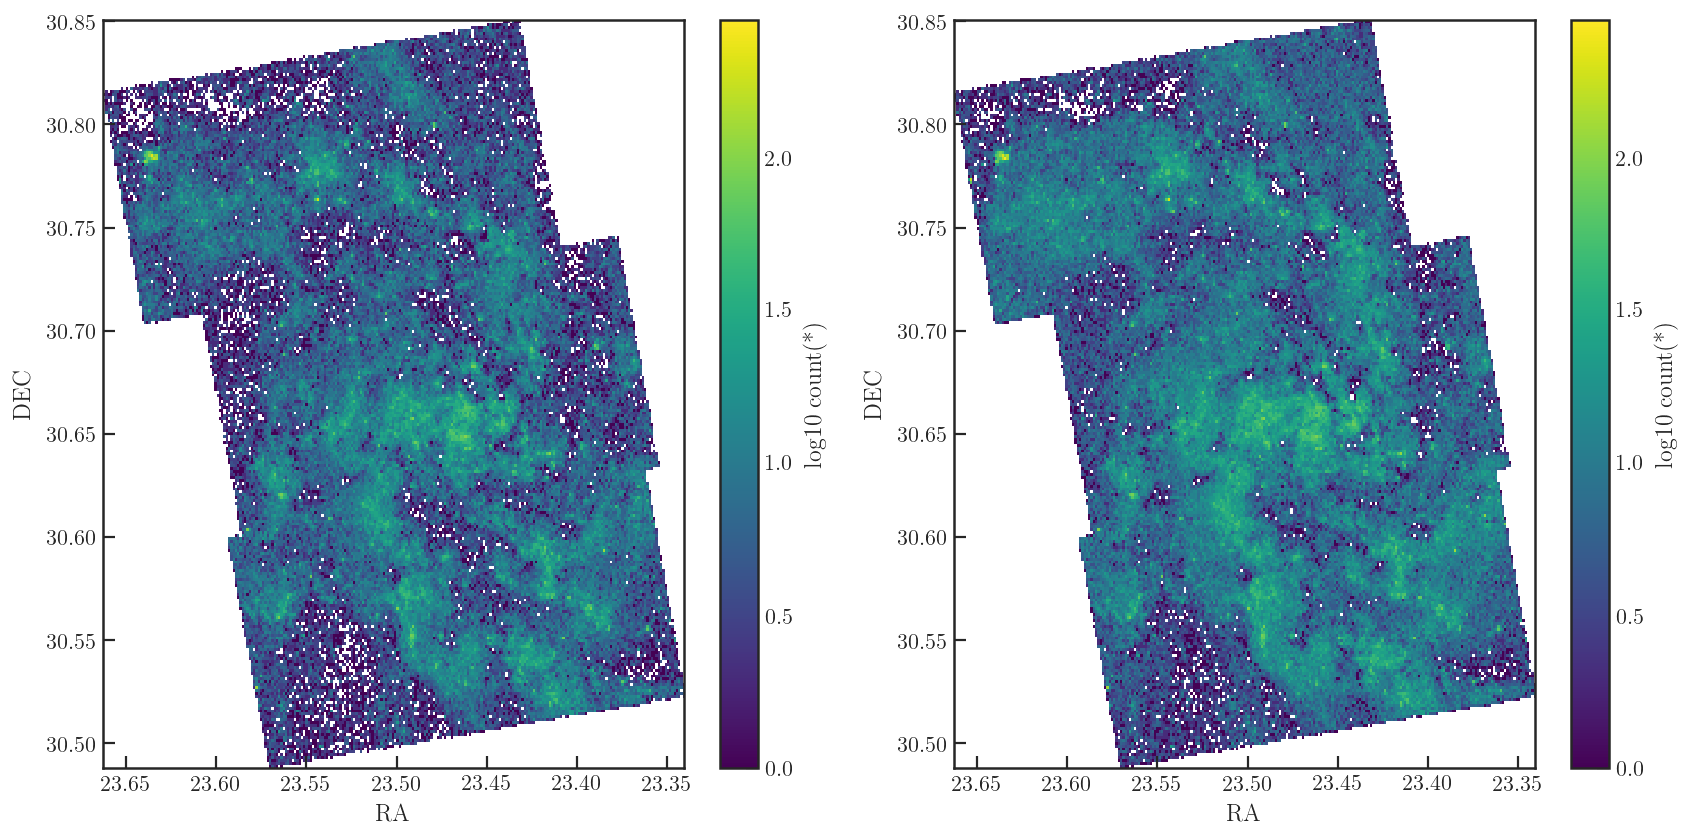

In [18]:
ds.plot('RA', 'DEC', f='log10', #xlabel='F336W--F475W', ylabel='F475W',
        limits='minmax', colormap='viridis', figsize=(12,6),
        selection=[ob_selection, ob_opt], visual=dict(column='selection'))
for ax in plt.gcf().get_axes():
    ax.invert_xaxis()

In [28]:
329522 / 3

109840.66666666667

In [19]:
ds_m31 = open_and_select('../../phat_legacy/M31.hdf5')

In [22]:
# M31: 10.68333, 41.26917, 77.5, 37.5, 24.45
distA, distB = deg_to_deproj(*ds_m31[['RA','DEC']].values.T,
                             ra0=10.68333, dec0=41.26917, i_deg=77.5,
                             pa_deg=37.5, dmod=24.45)
ds_m31['distA'] = distA
ds_m31['distB'] = distB
ds_m31['radius'] = (distA**2 + distB**2)**0.5

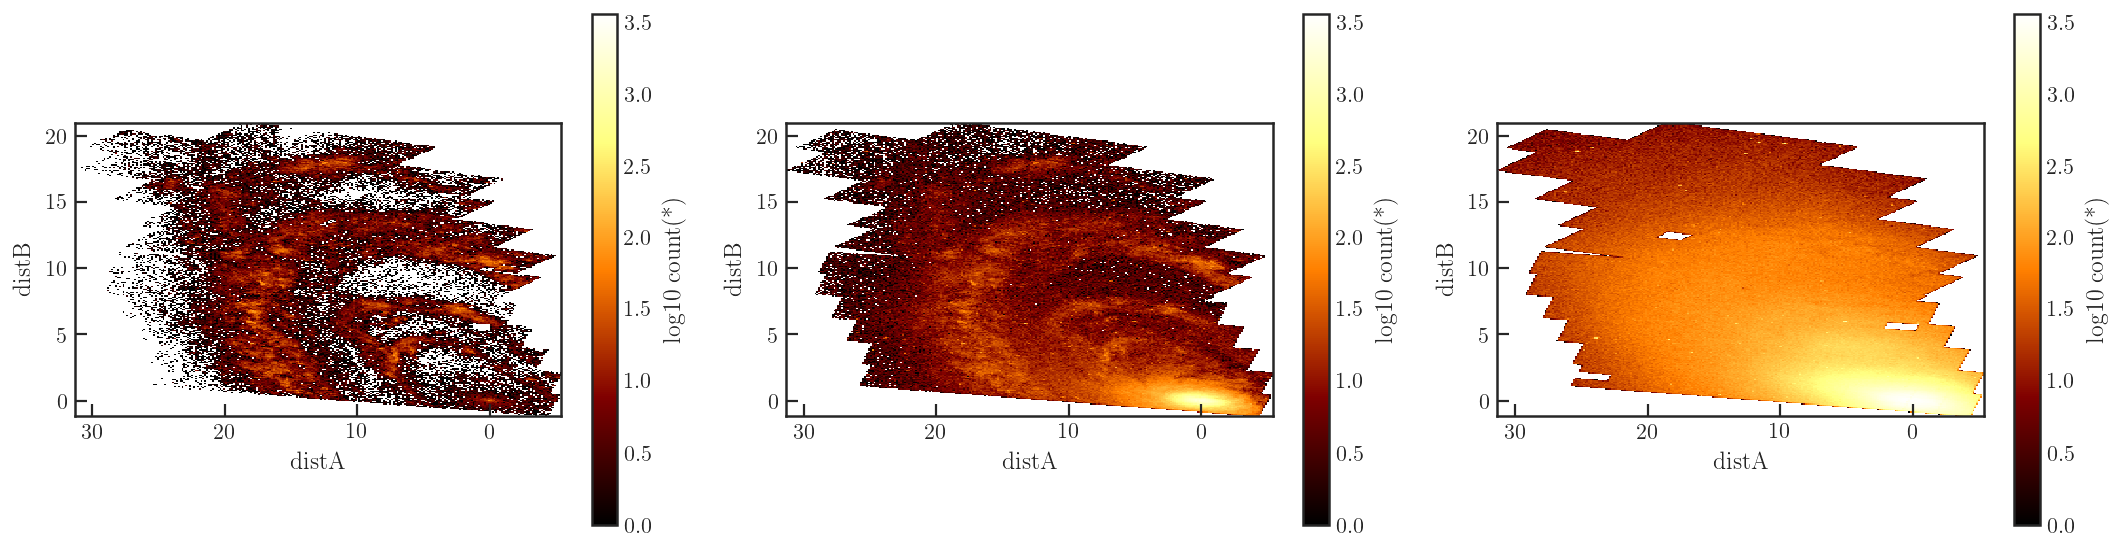

In [32]:
ds_m31.plot('distA', 'distB', f='log10', aspect=1, #limits=[0, 20],
            visual=dict(column='selection'), figsize=(15,4),
            selection=['(F275W_VEGA < 24.0) & (F336W_VEGA < 25) & UV_GST',
                       '(F475W_VEGA < 24.0) & (F814W_VEGA < 23.5) & OPT_GST',
                       '(F110W_VEGA < 21.5) & (F160W_VEGA < 21) & IR_GST'],
            wrap_columns=2,
)
for ax in plt.gcf().get_axes():
    ax.invert_xaxis()

In [24]:
ob_m31 = ob_selection.replace('24.7', '24.5')

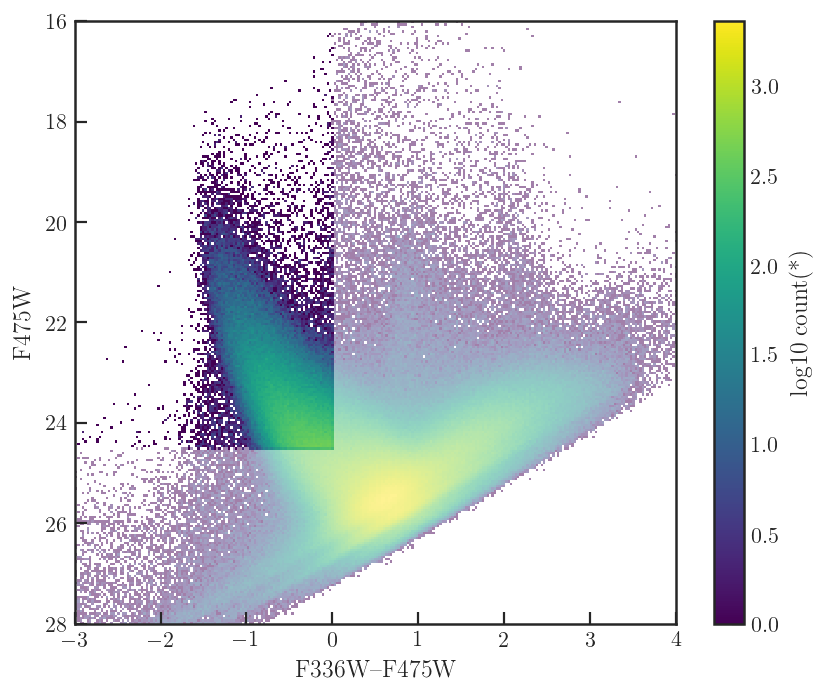

In [25]:
ds_m31.plot('F336W_VEGA-F475W_VEGA', 'F475W_VEGA', f='log10', xlabel='F336W--F475W', ylabel='F475W',
            limits=[[-3,4], [28, 16]], colormap='viridis', figsize=(6,5),
            selection=['F336W_GST & F475W_GST', ob_m31])

In [27]:
ds_m31.selected_length(ob_m31) / 23

9892.391304347826

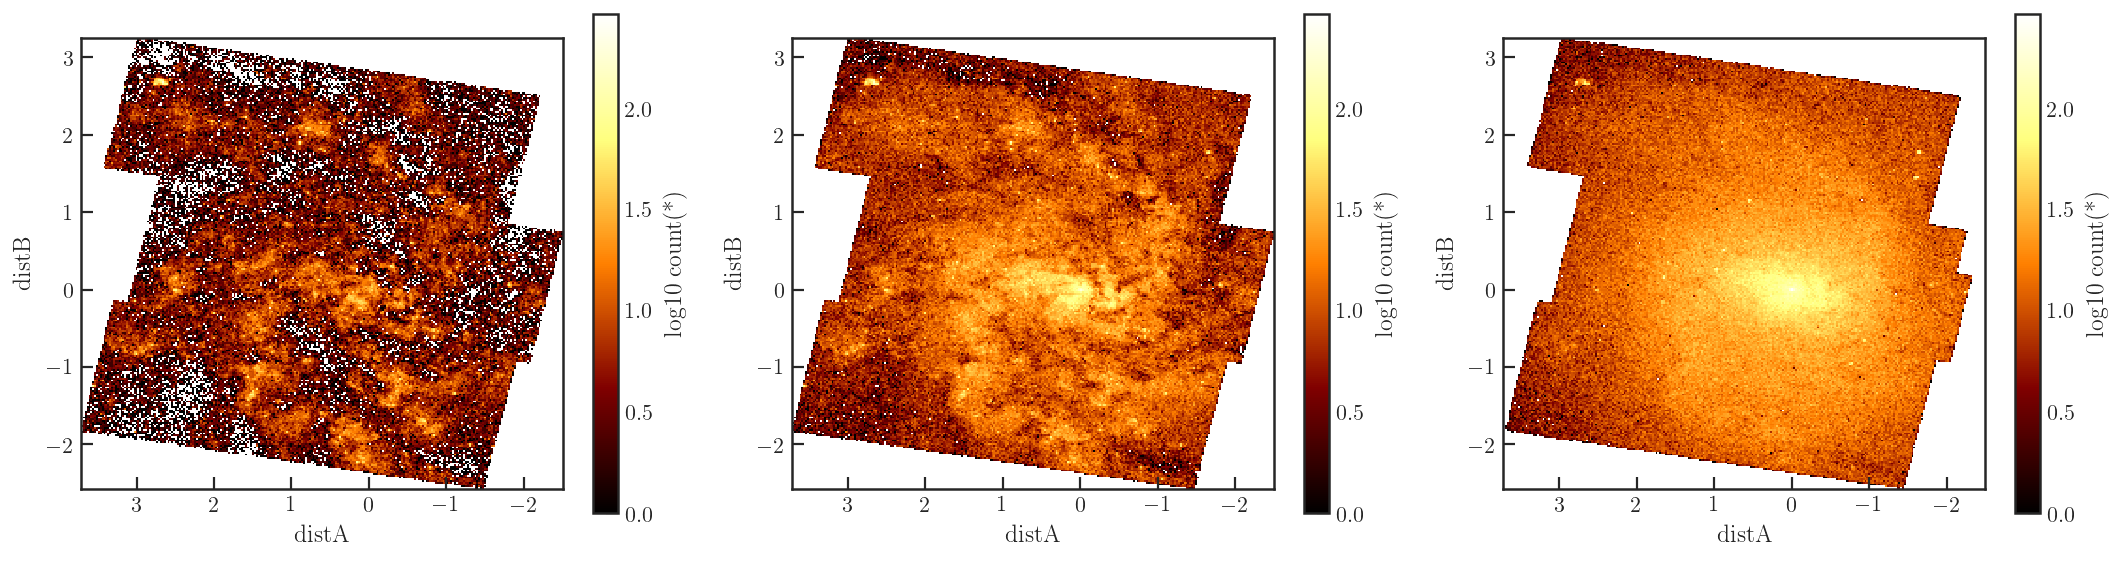

In [55]:
ds.plot('distA', 'distB', f='log10', aspect=1,
        visual=dict(column='selection'), figsize=(15,4),
        selection=['(F275W_VEGA < 24.0) & (F336W_VEGA < 25) & UV_GST',
                   '(F475W_VEGA < 24.5) & (F814W_VEGA < 24) & OPT_GST',
                   '(F110W_VEGA < 22.5) & (F160W_VEGA < 22) & IR_GST'],
)
for ax in plt.gcf().get_axes():
    ax.invert_xaxis()